In [1]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch

from models.cpm import CPM
from models.datasets.lsp import LSPet, LSP

import numpy as np
from vis import show_pose_from_hmap, show_hmap

from torch.utils.tensorboard import SummaryWriter

In [2]:
# Load data
batch_size = 8

image_size = (256, 256)
hmap_size = 32

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

lsp = LSPet('./dataset/lspet_dataset/', transform, image_size, hmap_size)
lsp_loader = DataLoader(lsp, batch_size, shuffle=True, num_workers=1)

In [3]:
# Initialize the model
model = CPM().cuda()

model.load_state_dict(torch.load('./cpm_weights/cpm10+4+9+2.weights'))

criterion = torch.nn.MSELoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [4]:
# Add network into tensorboard
data = next(iter(lsp_loader))

tb = SummaryWriter()
tb.add_graph(model, (data[0].cuda(), data[2].cuda()))
# tb.close()

In [5]:
# Train the model
for epoch in range(100):
    for batch, batch_data in enumerate(lsp_loader):

        model.zero_grad()

        input_image = batch_data[0].cuda()
        joints_hmap = batch_data[1].cuda()
        center_hmap = batch_data[2].cuda()
        # mask = batch_data[3].cuda()

        predictions = model(input_image, center_hmap)

        loss = 0
        for prediction in predictions:
            loss += criterion(prediction, joints_hmap) * 15360
        loss.backward()
        optimizer.step()

        # Tensorboard
        tb.add_scalar('Loss', loss, 1250*epoch + batch)

        if batch % 100 == 0:
            print('Batch: {}, Loss: {}, Epoch: {}'.format(batch, loss, epoch))
            # Add keypoints loss of testing data
    
    # Tensorboard
    for name, weight in model.named_parameters():
        tb.add_histogram(name, weight, epoch)
        tb.add_histogram(f'{name}.grad', weight.grad, epoch)        

    torch.cuda.empty_cache()
    torch.save(model.state_dict(), './cpm{}.weights'.format(epoch))

tb.close()

Batch: 0, Loss: 1995.8216552734375, Epoch: 0
Batch: 100, Loss: 1030.177001953125, Epoch: 0
Batch: 200, Loss: 1187.957275390625, Epoch: 0
Batch: 300, Loss: 878.546142578125, Epoch: 0
Batch: 400, Loss: 865.7711181640625, Epoch: 0
Batch: 500, Loss: 955.1488647460938, Epoch: 0
Batch: 600, Loss: 891.869384765625, Epoch: 0


KeyboardInterrupt: 

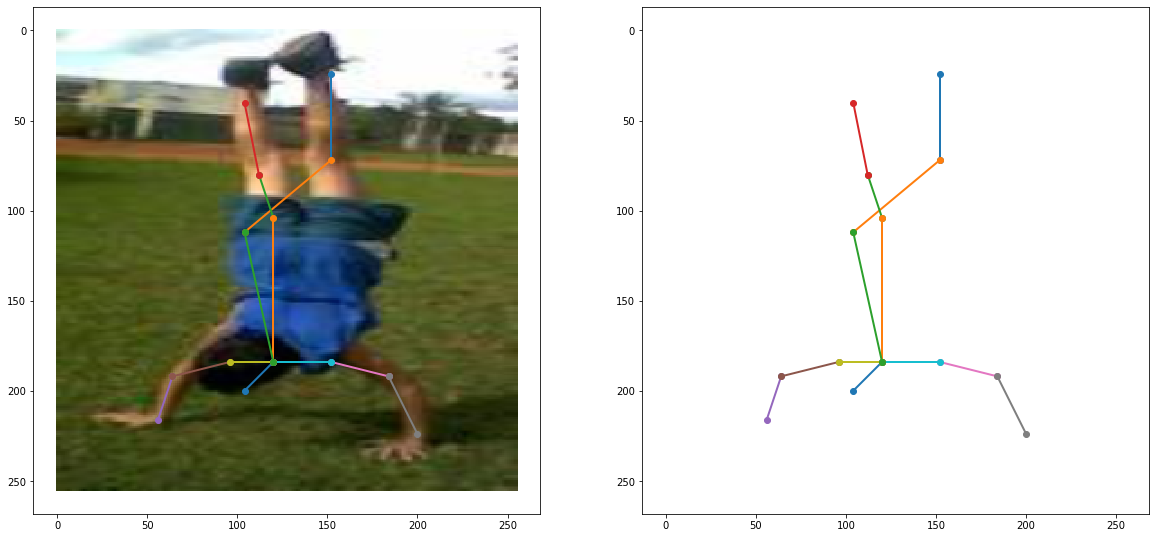

In [13]:
lsp_test = LSP('./dataset/lsp_dataset/', transform, image_size, hmap_size)
test_image, hmap, center_hmap, _ = lsp_test.__getitem__(np.random.randint(len(lsp_test)))
test_predictions =  model(test_image.unsqueeze(0).cuda(), center_hmap.unsqueeze(0).cuda())
show_pose_from_hmap(test_image, test_predictions[5].squeeze()[:14,:,:].cpu().detach())
# show_hmap(test_image, hmap)
# test_predictions[0].shape